- filtraggio dataframe con funzione recuparabile su github (aggiungi time delta)-->
mantieni solo dati sp500 (che caricherà lorenzo) che hanno date coincidenti con dataframe discorsi. 
- calcolo volatilità 
- calcolo volume

In [76]:
import pandas as pd
from helpermodules import memory_handling as mh
import numpy as np
import matplotlib.pyplot as plt

In [77]:
file = "fedspeechees_sentiment_2024.pkl"
helper = mh.PickleHelper.pickle_load(file)
df_sentiment = helper.obj


In [78]:
# downloading the pickle file 
file = "fedspeeches_preprocessed.pkl"
helper = mh.PickleHelper.pickle_load(file)
df_speech = helper.obj

In [79]:
df_speech = df_speech[df_speech['date']>='2024-01-01']
df_speech = df_speech.sort_values(['date','timestamp'], ascending=True)


In [80]:
df_speech_final = pd.merge(df_speech, df_sentiment[['timestamp', 'finbert_score','speaker']], on=['timestamp','speaker'], how='left')
df_speech_final.rename(columns={'title': 'speech'}, inplace=True)


In [81]:
def calculate_speech_durations(df_speech):
    """
    This function calculates the duration of each speech in dfspeeches.
    The duration is determined by counting how many rows correspond to each unique combination
    of 'date' and 'timestart'.

    Parameters:
    dfspeeches : pandas.DataFrame
        A dataframe containing ['date', 'timestart', 'speaker', 'title'] columns.

    Returns:
    pandas.DataFrame
        A dataframe containing ['date', 'timestart', 'speaker', 'title', 'duration'] columns, where 'duration'
        is the length of each speech in minutes.
    """
    # Ensure the 'date' column is in datetime format
    df_speech['date'] = pd.to_datetime(df_speech['date'])

    # Group by 'date', 'speaker', and 'title' and count the number of rows in each group
    speech_durations = df_speech.groupby(['date', 'speaker', 'speech']).size().reset_index(name='duration')

    # Merge the duration column back into the original DataFrame
    df_speech = df_speech.merge(speech_durations, on=['date', 'speaker', 'speech'], how='left')

    return df_speech


In [82]:
def find_timestart (df_speech):
    df_speech['date'] = pd.to_datetime(df_speech['date'])
    df_speech['timestamp'] = pd.to_datetime(df_speech['timestamp'])

    # Group by 'date', 'title', and 'speaker', and get the row with the minimum 'timestamp'
    grouped_df = (
        df_speech.loc[df_speech.groupby(['date', 'speech', 'speaker'])['timestamp'].idxmin()]
        .reset_index(drop=True)
    )
    
    return grouped_df


In [83]:

# Calculate speech durations
durations_df = calculate_speech_durations(df_speech_final)

#select just the first value for timestamp
durations_df = find_timestart(durations_df)


print(durations_df)

         date                                     speaker  \
0  2024-01-08                 Governor Michelle W. Bowman   
1  2024-01-16              Governor Christopher J. Waller   
2  2024-01-17  Vice Chair for Supervision Michael S. Barr   
3  2024-01-17                 Governor Michelle W. Bowman   
4  2024-02-02                 Governor Michelle W. Bowman   
..        ...                                         ...   
92 2024-10-10                       Governor Lisa D. Cook   
93 2024-10-11                 Governor Michelle W. Bowman   
94 2024-10-14              Governor Christopher J. Waller   
95 2024-10-18              Governor Christopher J. Waller   
96 2024-10-23                 Governor Michelle W. Bowman   

                                               speech  \
0   New Year’s Resolutions for Bank Regulatory Pol...   
1         Almost as Good as It Gets…But Will It Last?   
2                                     Opening Remarks   
3            The Path Forward for Bank 

In [84]:
def filtering(df_prices, df_speech, deltabefore=0, deltaafter=0):
    """
    This function filters dfprices by keeping only rows where the date is present in dfspeeches.
    Additionally, it considers the duration of speeches to filter rows in dfprices based on the time range.

    Parameters:
    dfprices : pandas.DataFrame
        A dataframe containing ['date', 'time', 'close', 'volume'] columns.
    dfspeeches: pandas.DataFrame
        A dataframe containing ['date', 'timestart', 'speaker', 'title'] columns.

    Returns:
    pandas.DataFrame
        A filtered dataframe containing only rows from dfprices where the 'date' and 'time' fall within the
        time range of speeches in dfspeeches.
    """
    # Ensure the 'date' and 'time' columns are in datetime format
    df_prices['date'] = pd.to_datetime(df_prices['date'])
    df_prices['datetime'] = pd.to_datetime(df_prices['datetime'])
    

    # Calculate speech durations
    durations_df = calculate_speech_durations(df_speech)

    #select just the first value for each timestamp
    durations_df = find_timestart(durations_df)
    
    # Initialize an empty list to store the filtered rows
    filtered_rows = []
    
    # Iterate over each speech to filter df_prices
    for _, speech in durations_df.iterrows():
        start_time = pd.to_datetime(speech['timestamp']) - pd.Timedelta(minutes=deltabefore)
        duration = speech['duration']
        
        
        # Calculate end time based on the duration
        end_time = pd.to_datetime(speech['timestamp']) + pd.Timedelta(minutes=duration + deltaafter)
        
        # Filter df_prices for the current speech date and time range
        mask = (df_prices['datetime'] >= start_time) & \
               (df_prices['datetime'] <= end_time)
        
        filtered_subset = df_prices[mask].copy()
        filtered_subset['speech'] = speech['speech']  # Add speech title or any other detail
        filtered_subset['speaker'] = speech['speaker']
        filtered_rows.append(filtered_subset)
    
    # Concatenate all filtered rows into a single dataframe
    filtered_df = pd.concat(filtered_rows,  ignore_index=True)
    
    return filtered_df


In [85]:
df = pd.read_csv("/Users/baudotedua/Dropbox/Mac/Documents/GitHub/cb-impact-nlps/US SPX 500 (Mini) 1 Minute (1).csv")
columns_to_keep = ['<Date>', ' <Time>', ' <Open>', ' <Close>', ' <TotalVolume>']
df = df[columns_to_keep]
df.columns = ['date', 'time', 'open', 'close', 'volume']
print(df.columns)
# combining date and time in one column (format datetime)
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'], format='%d/%m/%Y %H:%M:%S')
print(df['datetime'].dtype)
df = df.drop(columns=['time'])
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')
df = df[['datetime'] + [col for col in df.columns if col != 'datetime']]
df['datetime'] = df['datetime'].dt.tz_localize('America/New_York')
df_prices = df

Index(['date', 'time', 'open', 'close', 'volume'], dtype='object')
datetime64[ns]


In [86]:
deltabefore=10
deltaafter=10
df_prices_final = filtering(df_prices, df_speech_final, deltabefore, deltaafter)
df_prices_final.rename(columns={'datetime': 'timestamp'}, inplace=True)
df_prices_final['pct_change'] = df_prices_final.groupby(['speech', 'date'])['close'].pct_change()

In [87]:
print(df_speech_final['date'])
print(df_prices_final['date'])

0      2024-01-08
1      2024-01-08
2      2024-01-08
3      2024-01-08
4      2024-01-08
          ...    
1840   2024-10-23
1841   2024-10-23
1842   2024-10-23
1843   2024-10-23
1844   2024-10-23
Name: date, Length: 1845, dtype: datetime64[ns]
0      2024-01-08
1      2024-01-08
2      2024-01-08
3      2024-01-08
4      2024-01-08
          ...    
3709   2024-10-23
3710   2024-10-23
3711   2024-10-23
3712   2024-10-23
3713   2024-10-23
Name: date, Length: 3714, dtype: datetime64[ns]


In [88]:
df_speech_final = pd.merge(
    df_speech_final,
    df_prices_final[['date', 'speech', 'timestamp', 'pct_change']],
    on=['date', 'speech', 'timestamp'],
    how='right'
)


In [97]:
def volatility_calculator(df_prices_final, deltabefore=0, deltaafter=0):
    """
    Calculate daily volatility for the 'close' column in the dataframe.

    Parameters:
    df_prices_final : pandas.DataFrame
        A dataframe containing ['date', 'speech', 'close', 'volume'] columns.

    Returns:
    pandas.DataFrame
        A dataframe containing ['date', 'speech', 'volatility'] columns.
    """
    
    
    # Group by 'speech' and calculate the standard deviation of percentage changes
    if deltaafter != 0:
        # Filter rows based on indices, then group and calculate the standard deviation
        filtered_df = df_prices_final.iloc[deltabefore:-deltaafter]
        volatility_series = filtered_df.groupby('speech')['pct_change'].std()
    else:
        # Filter rows from deltabefore onward, then group and calculate the standard deviation
        filtered_df = df_prices_final.iloc[deltabefore:]
        volatility_series = filtered_df.groupby('speech')['pct_change'].std()
    # Convert the series into a dataframe
    volatility_df = volatility_series.reset_index()  # Resets the index to have 'speech' as a column
    
    # Rename the resulting columns for clarity
    volatility_df.rename(columns={'pct_change': 'volatility'}, inplace=True)
    
    # Merge with the original dataframe to include the 'date' column
    final_df = pd.merge(df_prices_final[['date', 'speech']].drop_duplicates(), 
                        volatility_df, 
                        on='speech', 
                        how='inner')
    
    return final_df


In [98]:
def get_best_values(volatility_df, number):
    """
    Get the top dates with the highest volatility from the given dataframe.

    Parameters:
    volatility_df : pandas.DataFrame
        A dataframe containing ['date', 'speech', 'volatility'] columns.
    number : int
        The number of top volatility records to return.

    Returns:
    pandas.DataFrame
        A dataframe with the top 'number' records, containing ['date', 'volatility'] columns.
    """
    # Drop rows with NaN values in the 'volatility' column to avoid issues
    volatility_df = volatility_df.dropna(subset=['volatility'])

    # Sort the dataframe by 'volatility' in descending order
    top_volatility_df = volatility_df.sort_values(by='volatility', ascending=False).head(number)

    # Select only the 'date' and 'volatility' columns for the result
    result_df = top_volatility_df[['date', 'volatility','speech']].drop_duplicates()

    return result_df


In [99]:
#example usage

#calculate the volatility over the whole delta time 

volatility = volatility_calculator(df_speech_final, deltabefore, deltaafter)
best_volatility = get_best_values(volatility , 10)
print(best_volatility)

         date  volatility                                             speech
69 2024-08-23    0.000720                                 Review and Outlook
33 2024-05-03    0.000659   Brief Remarks on the Economy and Monetary Policy
71 2024-09-06    0.000538                                  The Time Has Come
83 2024-10-01    0.000532  Artificial Intelligence, Big Data, and the Pat...
30 2024-04-05    0.000505  Risks and Uncertainty in Monetary Policy: Curr...
72 2024-09-10    0.000470  The Future of Stress Testing and the Stress Ca...
31 2024-04-16    0.000457  Economic Uncertainty and the Evolution of Mone...
86 2024-10-08    0.000443                 The Global Fight Against Inflation
88 2024-10-10    0.000413       Entrepreneurs, Innovation, and Participation
73 2024-09-10    0.000409                          The Next Steps on Capital


1) Funzione per plottare il pctchange overtime blu e rosso

2) funzione con bollinger bands 

3) pensa a come poter organizzare il codice su github con helpermodules e funzioni accessibili con nomi per eventuali cartelle e condizioni di accessibilità 


In [102]:
def plot_sentiment_vs_cumret(df, df_top_values, deltabefore, deltaafter, degree=2):
    """
    Plots sentiment scores and cumulative returns as line plots, with a polynomial approximation.

    Parameters:
    df : pandas.DataFrame
        The main dataframe containing data to plot.
    df_top_values : pandas.DataFrame
        Dataframe containing the top values to filter and plot.
    deltabefore : int
        Number of initial points to highlight in lighter color.
    deltaafter : int
        Number of final points to highlight in lighter color.
    degree : int, optional
        Degree of the polynomial approximation (default is 2).

    Returns:
    None
    """
    # Filter for top values
    best_speech = df_top_values['speech'].unique().tolist()
    df_filtered = df[df['speech'].isin(best_speech)]

    for speech_id, speech_group in df_filtered.groupby('speech'):
        pct_change = speech_group['pct_change'].values * 100
        sentiment_score = speech_group['finbert_score'].values
        time = speech_group['timestamp'].dt.tz_localize(None).values  # Remove timezone info
        date = speech_group['date'].dt.strftime('%m/%d/%y').unique()[0]

        

        # Ensure time is sorted
        sorted_indices = np.argsort(time)
        time = time[sorted_indices]
        pct_change = pct_change[sorted_indices]
        sentiment_score = sentiment_score[sorted_indices]

       

        # Apply z-score standardization
        def z_score_standardization(data):
            mean_val = np.nanmean(data)  # Ignore NaNs when calculating mean
            std_val = np.nanstd(data)    # Ignore NaNs when calculating std
            return (data - mean_val) / (std_val + 1e-10)

        pct_change = z_score_standardization(pct_change)
        sentiment_score = z_score_standardization(sentiment_score)

        # Plot both sentiment_score and pct_change as lines
        plt.figure(figsize=(10, 6))
        
        # Plot pct_change
        if deltaafter != 0:
            # First x values
            if deltabefore > 0:
                plt.plot(time[:deltabefore], pct_change[:deltabefore], color="lightblue", linewidth=0.75)

            # Middle values
            plt.plot(time[deltabefore:-deltaafter], pct_change[deltabefore:-deltaafter], color="blue", linewidth=1.5)

            # Last y values
            if deltaafter > 0:
                plt.plot(time[-deltaafter:], pct_change[-deltaafter:], color="lightblue", linewidth=0.75)
            
        else:
            if deltabefore > 0:
                plt.plot(time[:deltabefore], pct_change[:deltabefore], color="lightblue", linewidth=0.75)

            # Middle values
            plt.plot(time[deltabefore:], pct_change[deltabefore:], color="blue", linewidth=1.5)


        #plot sentiment 
        plt.plot(time, sentiment_score, color='red', label='Sentiment Score', linewidth=1.5)

        # Polynomial fit for sentiment_score
        coeffs_sentiment = np.polyfit(range(len(sentiment_score)), sentiment_score, degree)
        poly_sentiment = np.poly1d(coeffs_sentiment)
        plt.plot(time, poly_sentiment(range(len(time))), color='blue', linestyle='--', label=f'Cumulative Return Polynomial Approx (degree {degree})')

        # Add labels, legend, and title
        plt.xlabel('Time Period', fontsize=12)
        plt.ylabel('Values', fontsize=12)
        plt.title(f' {speech_id} in {date}', fontsize=14)
        plt.legend()
        plt.grid(alpha=0.3)

        # Show plot
        plt.show()


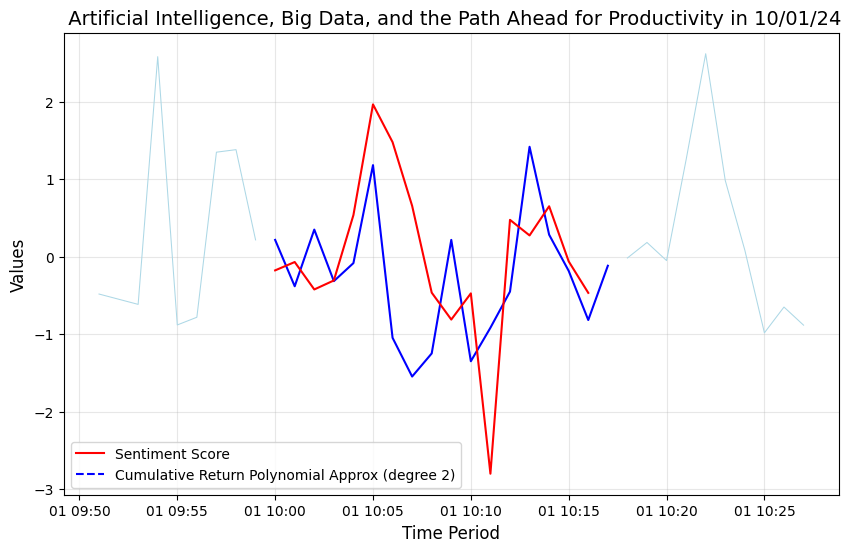

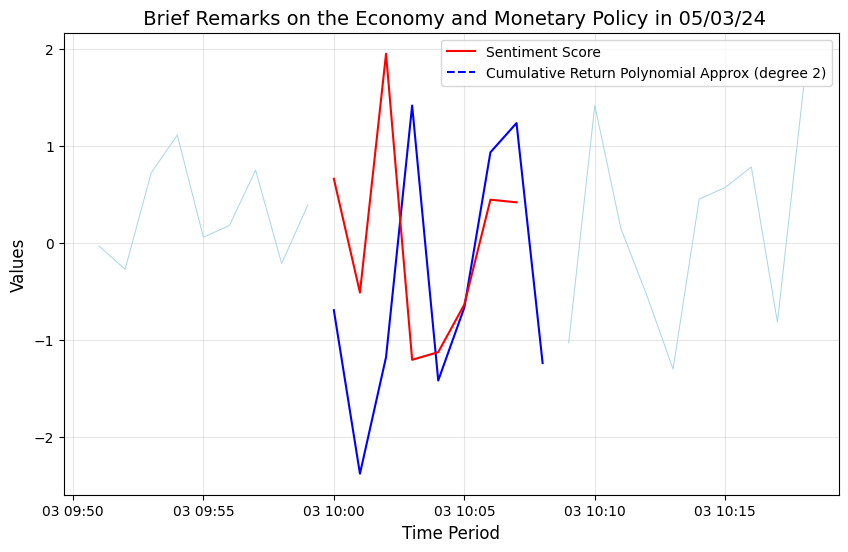

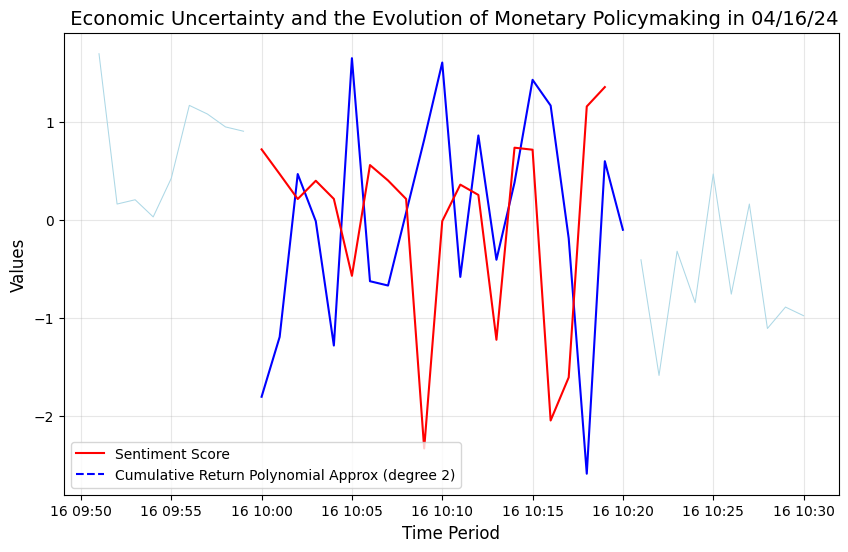

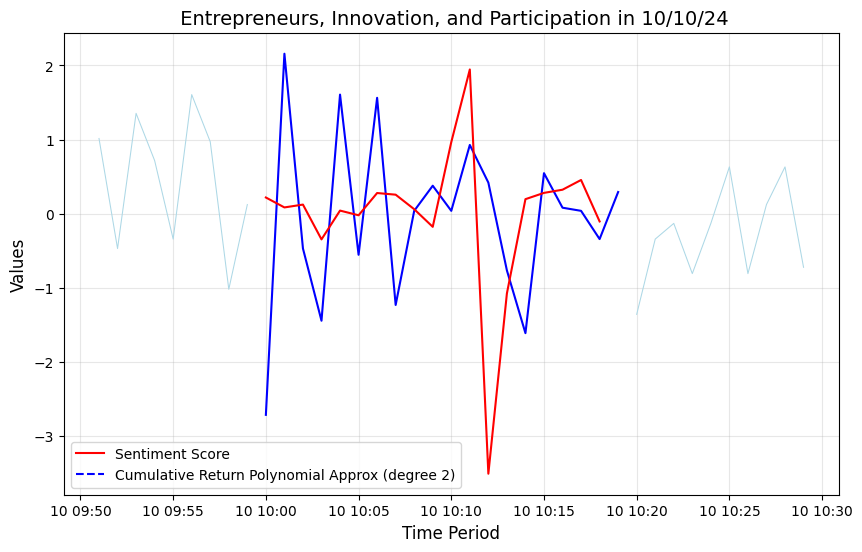

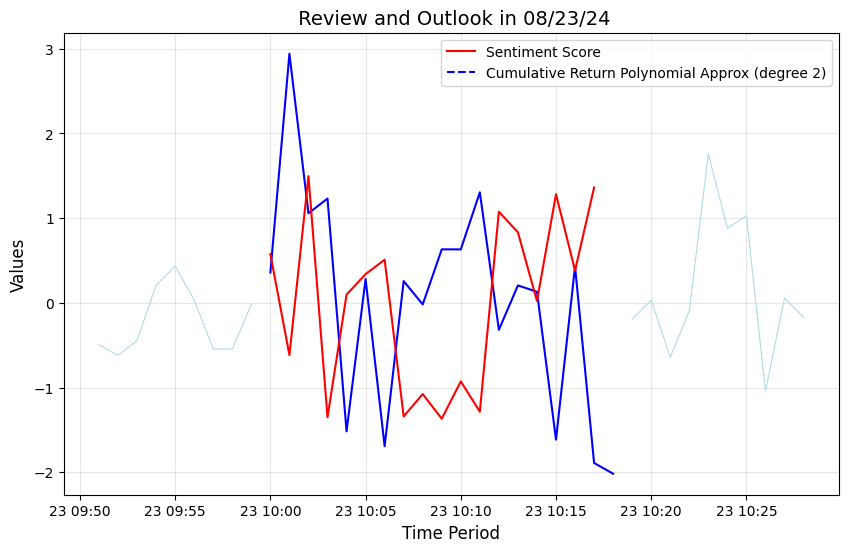

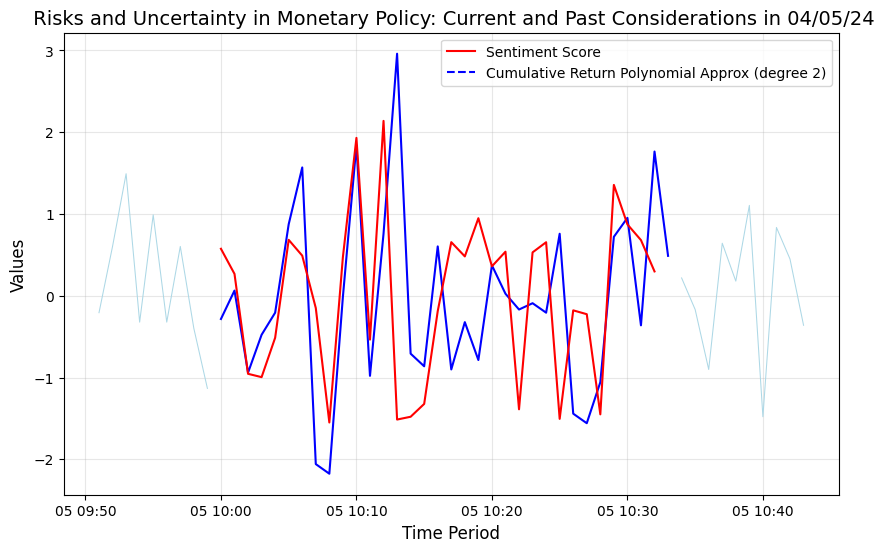

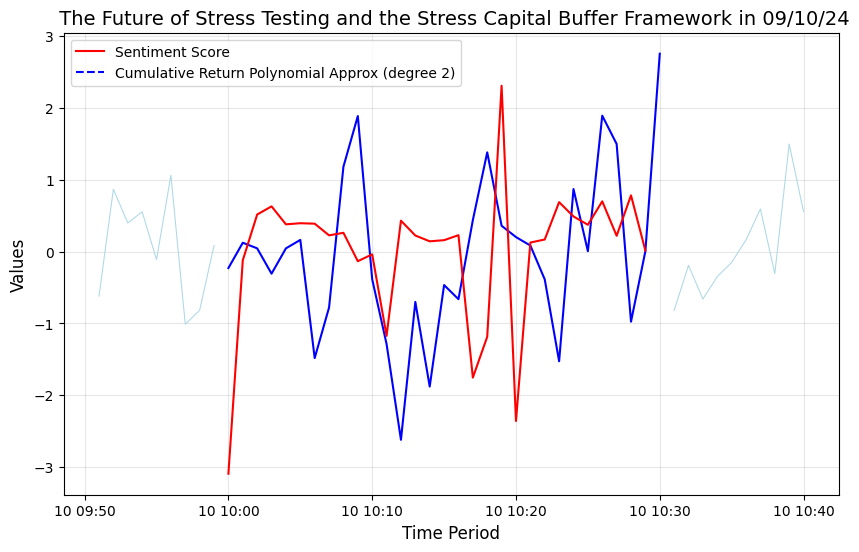

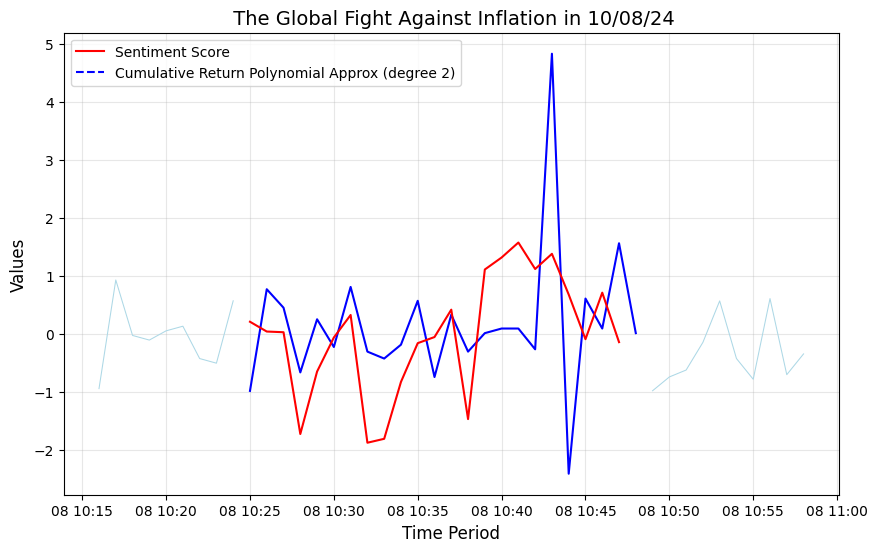

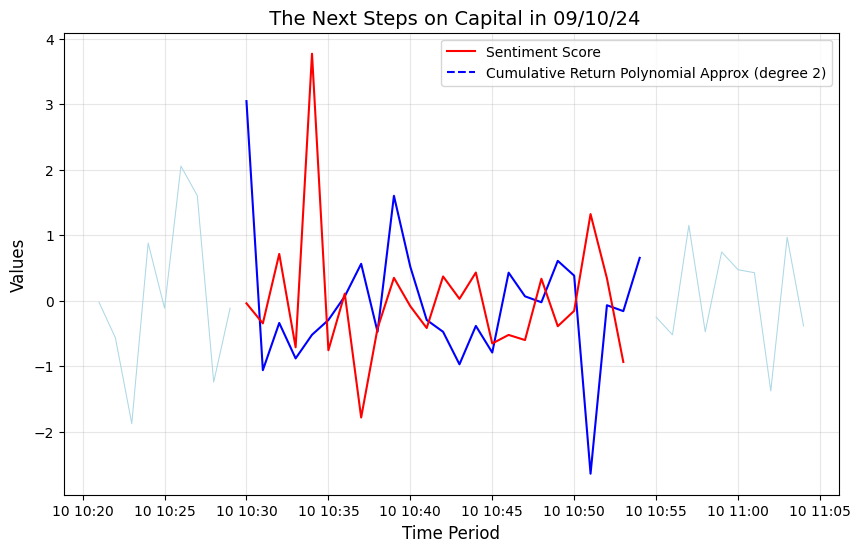

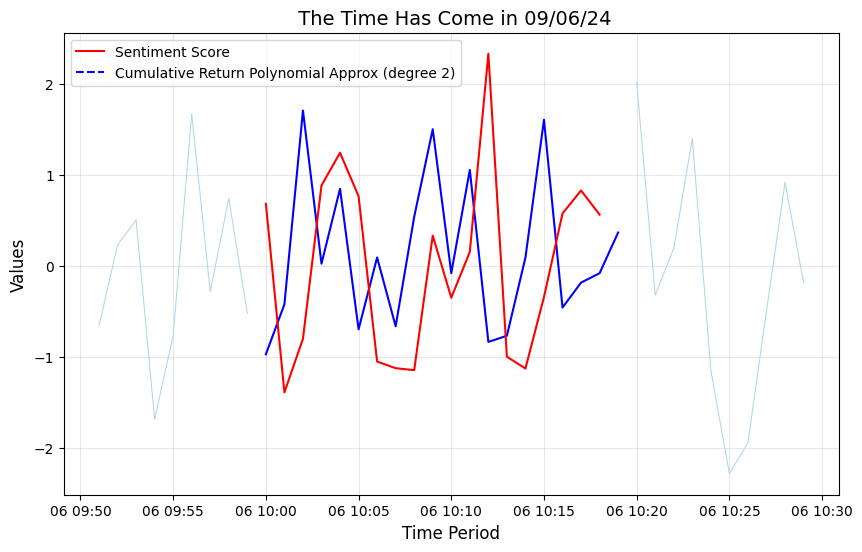

In [103]:
plot_sentiment_vs_cumret(df_speech_final, best_volatility, deltabefore, deltaafter)